In [58]:
import pandas as pd       
import os 
import math 
import numpy as np
import matplotlib.pyplot as plt
import librosa
from pydub import AudioSegment, silence
from pydub.silence import split_on_silence
import torch
import torch.nn as nn
import pickle
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from pathlib import Path

In [2]:
class MFCCDataset(Dataset):
    def __init__(self, root_dir):
        self.root_dir = root_dir
              
        self.mfccs = []
        self.labels = []
        
        for i in range(len(os.listdir(self.root_dir))):

            f = os.listdir(self.root_dir)[i]
            with open(self.root_dir / f, 'rb') as handle:
                entry = pickle.load(handle)
            self.mfccs.append(entry['data'])
            self.labels.extend(entry['labels'])
        
        self.mfccs = torch.from_numpy(np.vstack(self.mfccs).reshape(-1,3,20,22)).float()
        self.labels = torch.tensor(self.labels, dtype=torch.float)
    
    def __len__(self):
        
        return len(self.mfccs)

    def __getitem__(self, idx):
        
        return self.mfccs[idx], self.labels[idx]

In [3]:
speaker_csv = Path('C:/Users/omar_/Documents/cockatoos/data/accent_samples/speakers_all.csv')
speakers_df = pd.read_csv(speaker_csv)

In [4]:
original_dir = Path('C:/Users/omar_/Documents/cockatoos/data/accent_samples/recordings/recordings')
train_dir =  Path('C:/Users/omar_/Documents/cockatoos/data/train')
val_dir =  Path('C:/Users/omar_/Documents/cockatoos/data/val')
test_dir =  Path('C:/Users/omar_/Documents/cockatoos/data/test')

files = os.listdir(original_dir)


other_accent_types = ["mandarin", "japanese", "korean", "taiwanese", "cantonese", "thai", "indonesian"]

english_accent_files = []
other_accent_files = []

num_train_files = 200
num_val_files = 50
num_test_files = 48

# num_train_files = 50
# num_val_files = 19
# num_test_files = 19

end_idx_train = num_train_files
end_idx_val = end_idx_train + num_val_files
end_idx_test = end_idx_val + num_test_files


# for i in range(len(speakers_df)):
#     if df.loc[i]['file_missing?'] == False:
#         country = df.loc[i]['country']
#         if country == "usa":
#             english_accent_files.append(f"{df.loc[i]['filename']}.mp3")
#         elif country == "china":
#             other_accent_files.append(f"{df.loc[i]['filename']}.mp3")

for f in files:
    if "english" in f:
        english_accent_files.append(f)
    
    if any(t in f for t in other_accent_types):
        other_accent_files.append(f)


print(len(english_accent_files))
print(len(other_accent_files))

np.random.seed(100)
np.random.shuffle(english_accent_files)
np.random.shuffle(other_accent_files)
        
print(f"Number of english accent files: {len(english_accent_files)}")
print(f"Number of other accent files: {len(other_accent_files)}")

idxs = np.random.randint(100, size=100)
oversampled_other = other_accent_files[:100]

for n in idxs:
    oversampled_other.append(other_accent_files[n])

# train_files = english_accent_files[0:end_idx_train] + other_accent_files[0:end_idx_train]
# val_files   = english_accent_files[end_idx_train:end_idx_val] + other_accent_files[end_idx_train:end_idx_val]
# test_files  = english_accent_files[end_idx_val:end_idx_test] + other_accent_files[end_idx_val:end_idx_test]

train_files = english_accent_files[0:end_idx_train] + oversampled_other
val_files   = english_accent_files[200:250] + other_accent_files[100:150]
test_files  = english_accent_files[250:298] + other_accent_files[150:]

print(f"Number of training files: {len(train_files)}")
print(f"Number of validaiton files: {len(val_files)}")
print(f"Number of test files: {len(test_files)}")

579
198
Number of english accent files: 579
Number of other accent files: 198
Number of training files: 400
Number of validaiton files: 100
Number of test files: 96


In [79]:
def generate_dataset(df, files, size):
    count1 = 0
    count2 = 0
    for i in range(len(df)):
        if df.loc[i]['accent'] == 'us' and count1 < size:
            files.append((df.loc[i]['filename'], 0))
            count1 += 1
        elif df.loc[i]['accent'] == 'indian' and count2 < size:
            files.append((df.loc[i]['filename'], 1))
            count2 += 1

        if count1 == size and count2 == size:
            break
    return files

In [94]:
#Data setup for kaggle common voice dataset

data_train_src =  Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-train')
data_val_src=  Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-dev')
data_test_src =  Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-test')

train_csv = Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-train.csv')
val_csv = Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-dev.csv')
test_csv = Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-test.csv')

train_files = []
val_files = []
test_files = []

train_df = pd.read_csv(train_csv)
val_df = pd.read_csv(val_csv)
test_df = pd.read_csv(test_csv)

generate_dataset(train_df, train_files, 4000)
generate_dataset(val_df, val_files, 80)
generate_dataset(test_df, test_files, 80)
        

print(f"Number of training files: {len(train_files)}")
print(f"Number of validaiton files: {len(val_files)}")
print(f"Number of test files: {len(test_files)}")

Number of training files: 8000
Number of validaiton files: 160
Number of test files: 160


In [6]:
  def generate_mfcc_data(mfcc):
        mfcc_standardized = np.zeros(mfcc.shape)
        for b in range(mfcc.shape[0]):
            mfcc_slice = mfcc[b,:]
            centered = mfcc_slice - np.mean(mfcc_slice)
            if np.std(centered) != 0:
                centered_scaled = centered / np.std(centered)

            mfcc_standardized[b,:] = centered_scaled

        delta1 = librosa.feature.delta(mfcc_standardized, order=1)
        delta2 = librosa.feature.delta(mfcc_standardized, order=2)
        mfcc_data = np.stack((mfcc_standardized,delta1,delta2))
        
        return mfcc_data

In [ ]:
# path = Path('C:/Users/omar_/Documents/cockatoos/data/assess')
path = Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-train')
for f in ["cv-valid-train/sample-000023.mp3"]:
    segs = segment_and_standardize_audio(path/ f,100)
    #os.mkdir(Path('C:/Users/omar_/Documents/cockatoos') / "testingg")
    for i in range(len(segs)):      
        print(f"{i}: {np.count_nonzero(segs[i].get_array_of_samples())}")
    for i, s in enumerate(segs):
        if i < 10:
            prefix = "00"
        else:
            prefix = "0"
        s.export(Path('C:/Users/omar_/Documents/cockatoos') / "testingg" / f"chunk{prefix}{i}.wav" , format="wav")

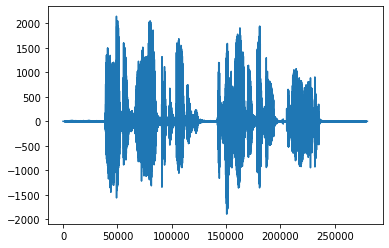

In [185]:
import matplotlib.pyplot as plt
from scipy.io import wavfile as wav
sound = AudioSegment.from_mp3(path / "cv-valid-train/sample-000005.mp3")
sound.export(Path('C:/Users/omar_/Documents/cockatoos') / "testingg" / "test.wav", format="wav")
rate, data = wav.read(Path('C:/Users/omar_/Documents/cockatoos') / "testingg" / "test.wav" )
%matplotlib inline
plt.plot(data)
plt.show()

In [23]:
# def segment_and_standardize_audio(path, seg_thresh):
#     sound_file = AudioSegment.from_mp3(path)
#     audio_chunks = split_on_silence(sound_file, 
#         # must be silent for at least half a second
#         min_silence_len = 5,

#         # consider it silent if quieter than -16 dBFS
#         silence_thresh=0
#     )
#     standardized_chunks = []
    
#     for seg in audio_chunks:
            
#         seg_len = len(seg)

#         if seg_len >= seg_thresh:
#             seg_standardized = seg[0:seg_thresh]
#         else:
#             seg_standardized = seg + AudioSegment.silent(duration=(seg_thresh - seg_len))
        
#         standardized_chunks.append(seg_standardized)
                
    
#     return standardized_chunks

In [78]:
def segment_and_standardize_audio(path, seg_size):
    sound_file = AudioSegment.from_mp3(path)
    limit = len(sound_file) // seg_size if len(sound_file) % seg_size == 0 else len(sound_file) // seg_size + 1
    chunks = []
    for i in range(0,limit):
        chunk = sound_file[i * seg_size : (i + 1) * seg_size]
        if len(chunk) < seg_size:
            chunk = chunk + AudioSegment.silent(duration=(seg_size - len(chunk)))
            
        if np.count_nonzero(chunk.get_array_of_samples()) > 4500:
            chunks.append(chunk)
    return chunks

In [80]:
def generate_model_data(src, dst, files, train, mean=0, std=1):
    
    counter = 0
    seg_thresh = 500
    batch_num = 1
    mfccs = []
    items = []
    labels = []
    n_mfcc = 20
    
    for f in files:
        
        # use for speech accent archive data
            
#         if "english" in f:
#             label = 1
#         else:
#             label = 0


#         audio_chunks = segment_and_standardize_audio(src / f, seg_thresh)

     
        # use for common voice data
        label = f[1]
        audio_chunks = segment_and_standardize_audio(src / f[0], seg_thresh)
        for seg in audio_chunks:
                 
            samples = seg.get_array_of_samples()
            arr = np.array(samples).astype(np.float32)/32768 # 16 bit 
            arr = librosa.core.resample(arr, seg.frame_rate, 22050, res_type='kaiser_best') 
                
            mfcc = librosa.feature.mfcc(y=arr, sr=22050, n_mfcc=n_mfcc)
            #data = generate_mfcc_data(mfcc)
            #items.append(data)
            mfccs.append(mfcc)
            labels.append(label)
            
#             if train:
#                 noise = np.random.normal(0,1, mfcc.shape)
#                 mfcc_noisy = mfcc + noise
#                 #noisy_data = generate_mfcc_data(mfcc_noisy)
#                 #items.append(noisy_data)
#                 mfccs.append(mfcc_noisy)
#                 labels.append(label)
    
    all_data = np.vstack(mfccs).reshape(-1,n_mfcc,22)
    if train:
        mean = all_data.mean(axis=0)
        std = all_data.std(axis=0)
        all_data = (all_data - mean) / std
    else:
        all_data = (all_data - mean) / std
    
    for j in range(all_data.shape[0]):
        d = generate_mfcc_data(all_data[j])
        items.append(d)
        
    max_batch_size = len(labels) // 5
    for j in range(0,len(items),max_batch_size):
        curr_data = items[j:j + max_batch_size]
        curr_labels = labels[j:j + max_batch_size]
        batch_mfcc = np.vstack(curr_data).reshape(-1,3,n_mfcc,22)
        entry = dict()
        entry['data'] = batch_mfcc
        entry['labels'] = curr_labels
        with open(dst / f'data_batch_{batch_num}.pickle', 'wb') as handle:
            pickle.dump(entry, handle, protocol=pickle.HIGHEST_PROTOCOL)
        batch_num += 1
        
    if train:
        return mean, std
            

In [95]:
#Uncomment to create the files for the dataset folders (common voice)

mean, std = generate_model_data(data_train_src, train_dir, train_files, True)
print("Training words created")
generate_model_data(data_val_src, val_dir, val_files, False, mean, std)
print("Validaiton words created")
generate_model_data(data_test_src, test_dir, test_files, False, mean, std)
print("Testing words created")

Training words created
Validaiton words created
Testing words created


In [13]:
#Uncomment to create the files for the dataset folders (speech accent archive)

mean, std = generate_model_data(original_dir, train_dir, train_files, True)
print("Training words created")
generate_model_data(original_dir, val_dir, val_files, False, mean, std)
print("Validaiton words created")
generate_model_data(original_dir, test_dir, test_files, False, mean, std)
print("Testing words created")

Training words created
Validaiton words created
Testing words created


In [96]:
train_data_dir = Path('C:/Users/omar_/Documents/cockatoos/data/train')
val_data_dir = Path('C:/Users/omar_/Documents/cockatoos/data/val')
test_data_dir = Path('C:/Users/omar_/Documents/cockatoos/data/test')

train_data = MFCCDataset(train_data_dir)
val_data = MFCCDataset(val_data_dir)
# test_data = MFCCDataset(test_data_dir)

In [14]:
print(len(train_data))

15448


In [36]:
print(len(train_data))

30896


In [98]:
print(train_data[0][0].shape)

torch.Size([3, 20, 22])


In [99]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [110]:
#Model definition
model = nn.Sequential(
            nn.Conv2d(3,32,3),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Conv2d(32,64,3),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2),
            nn.Dropout(0.5),
            nn.Flatten(1,3),
            nn.Linear(768,300),
            nn.Dropout(0.5),
            nn.Linear(300,1),
            nn.Sigmoid()
        ).to(device)

In [147]:
print(model)

Sequential(
  (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
  (1): ReLU()
  (2): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (5): ReLU()
  (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Dropout(p=0.5, inplace=False)
  (9): Flatten(start_dim=1, end_dim=3)
  (10): Linear(in_features=768, out_features=128, bias=True)
  (11): Dropout(p=0.5, inplace=False)
  (12): Linear(in_features=128, out_features=1, bias=True)
  (13): Sigmoid()
)


In [111]:
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
train_loader = DataLoader(train_data,batch_size=128,shuffle=True)
val_loader = DataLoader(val_data,batch_size=32,shuffle=True)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
epochs = 100
max_val_acc = 0

for epoch in range(epochs):

    running_loss = 0
    correct = 0
    for i, (inputs, labels) in enumerate(train_loader):
        model.train()
        optimizer.zero_grad()
        outputs = model(inputs.to(device))
        loss = nn.BCELoss()(outputs,labels.to(device).reshape(-1,1))
        running_loss += loss.item()
        loss.backward()
        optimizer.step()
        outputs = outputs.reshape(1, -1)
        outputs = outputs.squeeze()
        for i in range(outputs.size()[0]):
            if (labels[i] == 0 and outputs[i] < 0.5) or (labels[i] == 1 and outputs[i] >= 0.5):
                correct += 1

    if epoch % 10 == 0:
        with torch.no_grad():
            model.eval()
            val_loss = 0
            val_correct = 0
            for j, (d,l) in enumerate(val_loader):
                o = model(d.to(device))
                loss = nn.BCELoss()(o,l.to(device).reshape(-1,1))
                val_loss += loss.item()
                o = o.reshape(1,-1)
                o = o.squeeze()
                for i in range(o.size()[0]):
                    if (l[i] == 0 and o[i] < 0.5) or (l[i] == 1 and o[i] >= 0.5):
                        val_correct += 1

            accuracy = 100 * val_correct / len(val_data)
            if accuracy > max_val_acc:
                print('new record making model!')
                max_val_acc = accuracy
                #torch.save(model.state_dict(), args.model_path+'/model.pt')
            print(f"Validation loss for epoch {epoch}: {val_loss / len(val_loader)}, accuracy: {accuracy}")

    accuracy = 100 * correct / len(train_data)
    print(f"Epoch:{epoch}, avg loss for epoch:{running_loss / len(train_loader)}, accuracy: {accuracy}")

In [41]:
#Classifying specific set of audio samples
def predict(test_dir):
    
    predictions = dict()
    for f in os.listdir(test_dir):
        audio_chunks = segment_and_standardize_audio(test_dir / f, 500)
        num_english_pred = 0
        for seg in audio_chunks:

            samples = seg.get_array_of_samples()
            arr = np.array(samples).astype(np.float32)/32768 # 16 bit 
            arr = librosa.core.resample(arr, seg.frame_rate, 22050, res_type='kaiser_best') 

            mfcc = librosa.feature.mfcc(y=arr, sr=22050)
            data = generate_mfcc_data(mfcc)
            pred = model(torch.from_numpy(data).unsqueeze(0).float().to(device)).item()
            if pred > 0.5:
                num_english_pred += 1
        
        frac_english_preds = num_english_pred / len(audio_chunks)
        
        if frac_english_preds >= 0.5:
            predictions[f] = 1
        else:
            predictions[f] = 0
            
    return predictions

In [93]:
import pandas as pd
speaker_csv = Path('C:/Users/omar_/Documents/kaggle_voice/archive (1)/cv-valid-dev.csv')
df = pd.read_csv(speaker_csv)
print(len(df))
count = 0
#print(df.loc[0])
count1 = 0
count2 = 0
d = dict()
count = 0
for i in range(len(df)):
    if df.loc[i]['accent'] == "us":
        count1 += 1
    elif df.loc[i]['accent'] == "indian":
        count2 += 1
    

        
    
#     if df.loc[i]['accent'] == 'us':
#         count1 += 1
#     elif df.loc[i]['accent'] == 'indian':
#         count2 += 1
        
print(count1)
print(count2)

4076
637
89
